In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
# Configure TensorFlow to use GPU for faster computation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Load the Fashion MNIST dataset
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.VM0DPL_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.VM0DPL_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Data Transformation: Scale and Vizualize Images
import numpy as np

# Setup data iterator
dataiterator = ds.as_numpy_iterator()

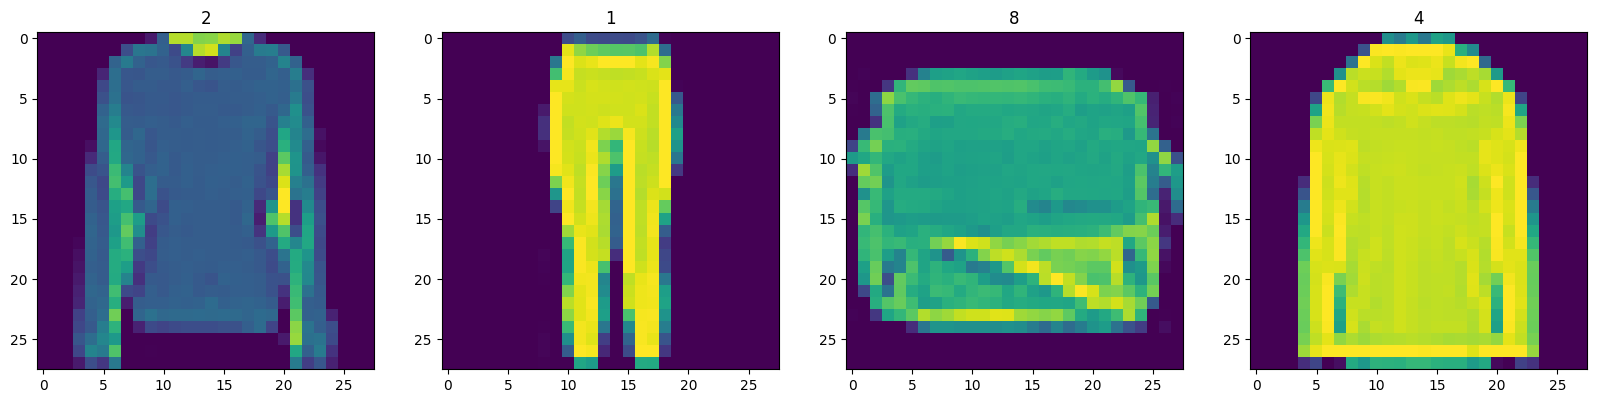

In [ ]:
# Visualize some images from the dataset
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Loop four times and get images
for idx in range(4):
    # Grab an image and its label
    sample = dataiterator.next()
    image = np.squeeze(sample['image'])  # Remove the single-dimensional entries
    label = sample['label']

    # Plot the image using a specific subplot
    ax[idx].imshow(image)
    ax[idx].title.set_text(label)

In [ ]:
# Data Preprocessing: Scale and Batch the Images
def scale_images(data):
    # Scale the pixel values of the images between 0 and 1
    image = data['image']
    return image / 255

In [ ]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')

In [ ]:
# Apply the scale_images preprocessing step to the dataset
ds = ds.map(scale_images)

In [ ]:
# Shuffle the dataset to add randomness to the training process
ds = ds.shuffle(60000)

# Batch the dataset into smaller groups (128 images per batch)
ds = ds.batch(128)

# Prefetch the dataset to improve performance during training
ds = ds.prefetch(64)

# Check the shape of a batch of images
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [ ]:
# Import the Sequential API for building models
from tensorflow.keras.models import Sequential

# Import the layers required for the neural network
from tensorflow.keras.layers import (
    Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
)

In [ ]:
def build_generator():
    model = Sequential()

    # First layer takes random noise and reshapes it to 7x7x128
    # This is the beginning of the generated image
    model.add(Dense(7 * 7 * 128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [ ]:
# Build the generator model
generator = build_generator()
# Display the model summary
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 364ms/step


(4, 28, 28, 1)

In [ ]:
def build_discriminator():
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Convolutional Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Convolutional Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Convolutional Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten the output and pass it through a dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# Build the discriminator model
discriminator = build_discriminator()
# Display the model summary
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = img[0]
img.shape

(28, 28, 1)

In [ ]:
# Import the Adam optimizer and Binary Cross Entropy loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define the optimizers for the generator and discriminator
g_opt = Adam(learning_rate=0.0001)  # Generator optimizer
d_opt = Adam(learning_rate=0.00001)  # Discriminator optimizer

# Define the loss functions for the generator and discriminator
g_loss = BinaryCrossentropy()  # Generator loss function
d_loss = BinaryCrossentropy()  # Discriminator loss function

In [ ]:
from tensorflow.keras.models import Model

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to the base class
        super().__init__(*args, **kwargs)

        # Create attributes for generator and discriminator models
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with the base class
        super().compile(*args, **kwargs)

        # Create attributes for optimizers and loss functions
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data for real images
        real_images = batch
        # Generate fake images using the generator with random noise as input
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass real and fake images through the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the true outputs to make training more robust
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate the total discriminator loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation and update discriminator weights
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate new images using the generator with random noise as input
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create the predicted labels (should be close to 1 as they are fake images)
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate the total generator loss (tricking the discriminator to classify the fake images as real)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation and update generator weights
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [ ]:
# Create an instance of the FashionGAN model
fashgan = FashionGAN(generator, discriminator)

# Compile the model with the optimizers and loss functions
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # Generate random latent vectors as input to the generator
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        # Generate fake images using the generator
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            # Save the generated images to disk
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/Generative Adversarial Neural Network/images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
# Train the GAN model
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
 28/469 [>.............................] - ETA: 3:27:57 - d_loss: 0.6935 - g_loss: 0.7073

In [ ]:
import matplotlib.pyplot as plt

# Plot the discriminator and generator losses
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
# Load the weights of the trained generator
generator.load_weights('/content/drive/MyDrive/Colab Notebooks/Generative Adversarial Neural Network/models/generator.h5')

# Generate new fashion images
imgs = generator.predict(tf.random.normal((16, 128, 1)))

# Plot the generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r + 1) * (c + 1) - 1])

In [ ]:
# Save the generator and discriminator models
generator.save('/content/drive/MyDrive/Colab Notebooks/Generative Adversarial Neural Network/models/generator.h5')
discriminator.save('/content/drive/MyDrive/Colab Notebooks/Generative Adversarial Neural Network/models/discriminator.h5')